In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [3]:
input_location = ''
schedule_names = ['fcfs', 'fcfs-easy', 'filler', 'fcfs-bb', 'sjf-bb', 'plan-1', 'plan-2', 'plan-3']
# schedule_names = ['fcfs', 'fcfs-easy', 'filler', 'fcfs-bb', 'sjf-bb']

In [7]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_jobs.csv'):
        jobs_files.append(file)

jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(jobs_files)

['../output/fcfs-bb_jobs.csv', '../output/fcfs-easy_jobs.csv', '../output/fcfs_jobs.csv', '../output/filler_jobs.csv', '../output/sjf-bb_jobs.csv']


In [8]:
jobsets = {}
for file in jobs_files:
    schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

fcfs-bb
fcfs-easy
fcfs
filler
sjf-bb


In [9]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [10]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [11]:
def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [12]:
metrics_df = create_all_metrics_df()
metrics_df.waiting_time /= 60 * 60

In [13]:
waiting_times = create_metric_df('waiting_time')

Text(0.5, 0, '')

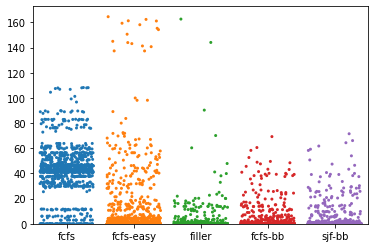

In [15]:
# Waiting time tail distribution
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']] for schedule in schedule_names])
fig, ax = plt.subplots()
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylabel('')
ax.set_xlabel('')

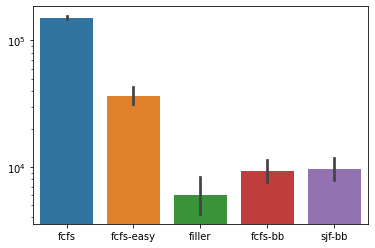

In [18]:
# Mean waiting time
fig, ax = plt.subplots()
sns.barplot(data=waiting_times, ax=ax)
ax.set_yscale('log')

(1, 1886915.4855587753)

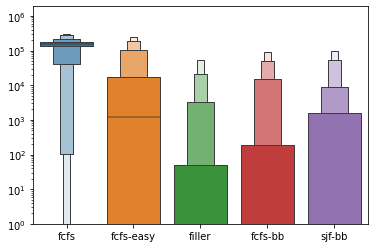

In [23]:
# Waiting time quantiles
fig, ax = plt.subplots()
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)

Text(0.5, 0, '')

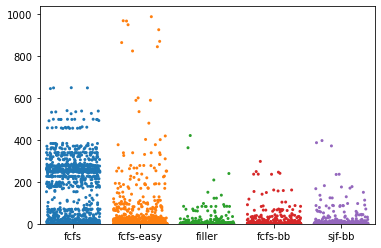

In [24]:
# Bounded slowdown tail dist.
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']] for schedule in schedule_names])
fig, ax = plt.subplots()
sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 0, '')

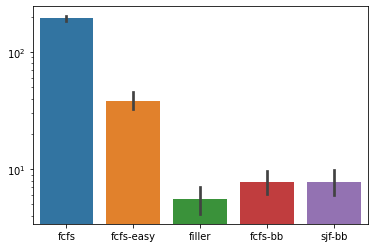

In [25]:
# Mean bounded slowdown
fig, ax = plt.subplots()
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_yscale('log')
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 0, '')

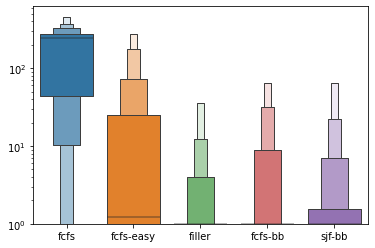

In [26]:
# Bounded slowdown quantiles
fig, ax = plt.subplots()
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1)
ax.set_ylabel('')
ax.set_xlabel('')